In [1]:
import tensorflow as tf
import os
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
import pandas as pd
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
import pathlib
data_dir = pathlib.Path("images")

In [4]:
img_count = len(list(data_dir.glob('*/*')))
img_count

8750

In [5]:
CLASS_NAME = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAME

array(['bird', 'cat', 'deer', 'dog', 'rabbit', 'raccoon', 'squirrel'],
      dtype='<U8')

In [6]:
BATCH_SIZE=32
IMG_HEIGHT = 224
IMG_WIDTH=224

In [17]:
#load all the files from image folder
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [18]:
#Filenames
for f in list_ds.take(5):
    print(f)

tf.Tensor(b'images\\cat\\cat.383.jpg', shape=(), dtype=string)
tf.Tensor(b'images\\deer\\57bdf75cbca30683b7.jpg', shape=(), dtype=string)
tf.Tensor(b'images\\bird\\Gray_Catbird_0007_530833749.jpg', shape=(), dtype=string)
tf.Tensor(b'images\\raccoon\\ec31bf026b34761d9e.jpg', shape=(), dtype=string)
tf.Tensor(b'images\\rabbit\\rabbit239.jpg', shape=(), dtype=string)


In [19]:
SIZE = len(list(list_ds))
print("Total number of images:",SIZE)

Total number of images: 8750


In [20]:
#shuffle the data
list_ds = list_ds.shuffle(8750,seed=42)

In [21]:
#train:70%,validate:10%,test:20%
train_ds_size = int(0.70*SIZE)
validate_ds_size = int(0.1*SIZE)

In [22]:
#Split into train,validate,test datasets
train_ds = list_ds.take(train_ds_size)
remains = list_ds.skip(train_ds_size)
validate_ds = remains.take(validate_ds_size)
test_ds = remains.skip(validate_ds_size)

In [23]:
print(len(list(train_ds)))
print(len(list(validate_ds)))
print(len(list(test_ds)))

6125
875
1750


In [24]:
#convert file path to (img,label)
def get_label(file_path):
    #convert path to a list of path components
    parts = tf.strings.split(file_path,os.path.sep)
    #sec to last is the class directory
    return parts[-2] == CLASS_NAME #compare to list of animals, return [f,f,t,f...]

In [25]:
def decode_img(img):
    #convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img,channels=3)
    #convert to floats in the [0,1] range
    img =tf.image.convert_image_dtype(img,tf.float32)
    #resize the image to the desired size.
    return tf.image.resize(img,[IMG_WIDTH,IMG_HEIGHT])

In [26]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img,label

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
validate = validate_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test = test_ds.map(process_path,num_parallel_calls=AUTOTUNE)

In [28]:
BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=1000

In [29]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validate.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [30]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAME[label_batch[n]==1][0].title())
      plt.axis('off')

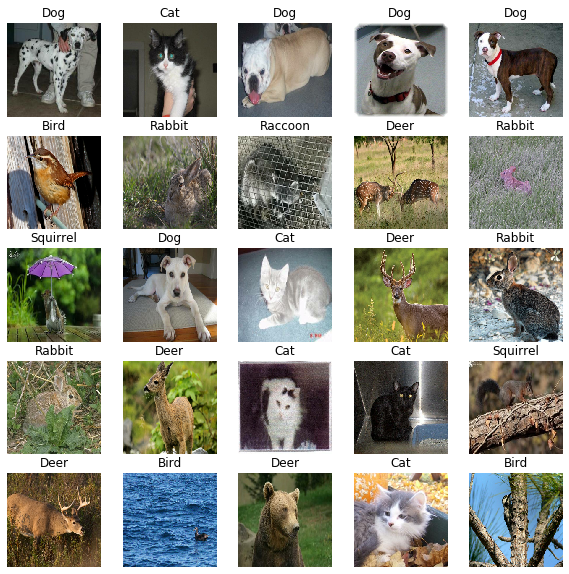

In [31]:
for image_batch, label_batch in train_batches.take(1):
    pass
show_batch(image_batch.numpy(),label_batch.numpy())

In [32]:
#You will create the base model from the MobileNet V2 model developed at Google.
#This is pre-trained on the ImageNet dataset, a large dataset consisting 
#of 1.4M images and 1000 classes. 
IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [33]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [34]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [36]:
prediction_layer = tf.keras.layers.Dense(7,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 7)


In [37]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [38]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
len(model.trainable_variables)

2

In [41]:
initial_epochs=10
validation_steps=20
history = model.fit(train_batches,
                   epochs=initial_epochs,
                   validation_data=validation_batches)

Epoch 1/10
192/192 [==============================] - 219s 1s/step - loss: 0.4550 - accuracy: 0.8700 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
192/192 [==============================] - 212s 1s/step - loss: 0.1665 - accuracy: 0.9509 - val_loss: 0.2279 - val_accuracy: 0.9417
Epoch 3/10
192/192 [==============================] - 212s 1s/step - loss: 0.1284 - accuracy: 0.9621 - val_loss: 0.2892 - val_accuracy: 0.9200
Epoch 4/10
192/192 [==============================] - 216s 1s/step - loss: 0.1145 - accuracy: 0.9629 - val_loss: 0.1832 - val_accuracy: 0.9509
Epoch 5/10
192/192 [==============================] - 218s 1s/step - loss: 0.0979 - accuracy: 0.9716 - val_loss: 0.2157 - val_accuracy: 0.9417
Epoch 6/10
192/192 [==============================] - 218s 1s/step - loss: 0.0936 - accuracy: 0.9687 - val_loss: 0.2735 - val_accuracy: 0.9223
Epoch 7/10
192/192 [==============================] - 217s 1s/step - loss: 0.0736 - accuracy: 0.9773 - val_loss: 0.1848 - val_accuracy

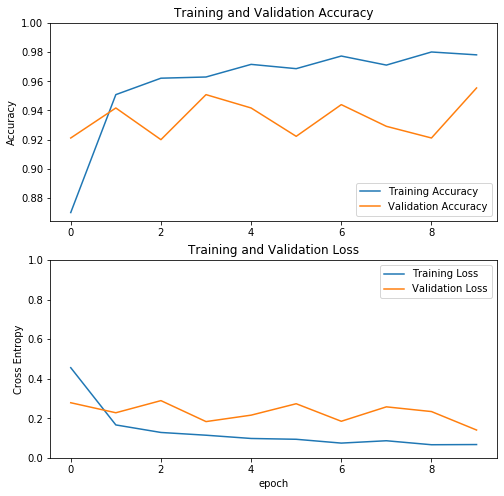

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
model.evaluate(test_batches)

55/55 [==============================] - 52s 950ms/step - loss: 0.1598 - accuracy: 0.9543


[0.15982562647285786, 0.95428574]

In [79]:
def find_preds(predicts):
    actual_pred =[]
    for p in predicts:
        max_i=0
        for i in range(1,len(p)):
            if p[i] > p[max_i]:
                max_i = i
        actual_pred.append(max_i)
    return actual_pred

In [47]:
CLASS_NAME[actual_pred[0]]

'squirrel'

In [86]:
def show_test_batch(image_batch,label_batch,preds):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(str(CLASS_NAME[preds[n]])+" vs "+str(CLASS_NAME[label_batch[n]==1][0].title()) )
        plt.axis('off')

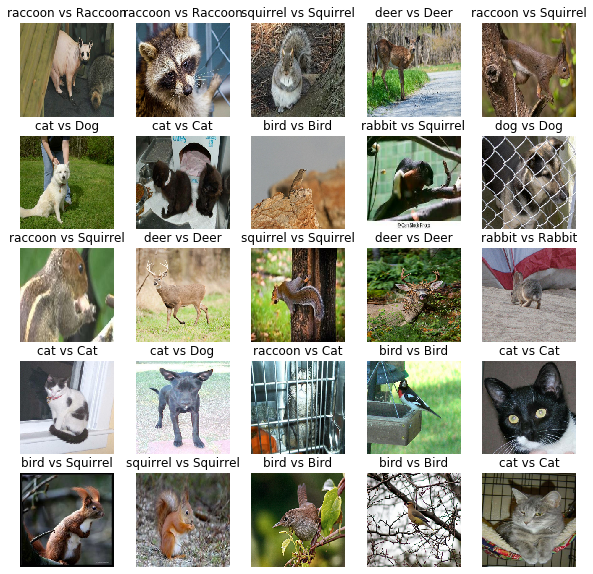

In [90]:
#inspect few results
for test_batch, label_batch in test_batches.take(1):
    pass
predicts = model.predict(test_batch)
actual_pred = find_preds(predicts)
show_test_batch(test_batch.numpy(),label_batch.numpy(),actual_pred)